<a href="https://colab.research.google.com/github/rdesarz/zoo/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Check for Tensorflow version
print(tf.__version__)

# Check if there is an existing GPU device
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.8.0
Found GPU at: /device:GPU:0


In [ ]:
# We use the CIFAR-10 datasets for this example
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

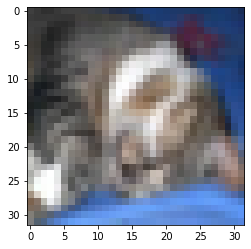

In [ ]:
image_index = np.random.randint(low=0, high = train_images.shape[0])
plt.imshow(train_images[image_index])

In [ ]:
# Processing function
def process_image(image, label):
  image=tf.image.per_image_standardization(image)
  image=tf.image.resize(image,(64,64))

  return image, label

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_ds_size = tf.data.experimental.cardinality(train_dataset).numpy()
test_ds_size = tf.data.experimental.cardinality(test_dataset).numpy()

In [ ]:
train_dataset=(train_dataset
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True))
test_dataset=(test_dataset
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True))

In [ ]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters = 96, kernel_size=(11,11), strides=(4,4), 
                        activation="relu", input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters = 256, kernel_size=(5, 5), strides=(1, 1), 
                        activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters = 384, kernel_size=(3, 3), strides=(1, 1), 
                        activation="relu", padding="same"),
    keras.layers.Conv2D(filters = 384, kernel_size=(3, 3), strides=(1, 1), 
                        activation="relu", padding="same"),
    keras.layers.Conv2D(filters = 256, kernel_size=(3, 3), strides=(1, 1), 
                        activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  
])

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']    
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         614656    
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 256)        1024      
 hNormalization)                                                 
                                                        

In [ ]:
history=model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    validation_freq=1
)

Epoch 1/50
1562/1562 [==============================] - 57s 26ms/step - loss: 1.8894 - accuracy: 0.3152 - val_loss: 1.4722 - val_accuracy: 0.4675
Epoch 2/50
1562/1562 [==============================] - 46s 26ms/step - loss: 1.4812 - accuracy: 0.4674 - val_loss: 1.2717 - val_accuracy: 0.5442
Epoch 3/50
1562/1562 [==============================] - 46s 26ms/step - loss: 1.2884 - accuracy: 0.5410 - val_loss: 1.1480 - val_accuracy: 0.5922
Epoch 4/50
1562/1562 [==============================] - 48s 27ms/step - loss: 1.1578 - accuracy: 0.5905 - val_loss: 1.0833 - val_accuracy: 0.6222
Epoch 5/50
1562/1562 [==============================] - 46s 26ms/step - loss: 1.0515 - accuracy: 0.6321 - val_loss: 1.0472 - val_accuracy: 0.6273
Epoch 6/50
1562/1562 [==============================] - 46s 26ms/step - loss: 0.9589 - accuracy: 0.6656 - val_loss: 0.9951 - val_accuracy: 0.6586
Epoch 7/50
1562/1562 [==============================] - 46s 26ms/step - loss: 0.8769 - accuracy: 0.6924 - val_loss: 0.9936 -

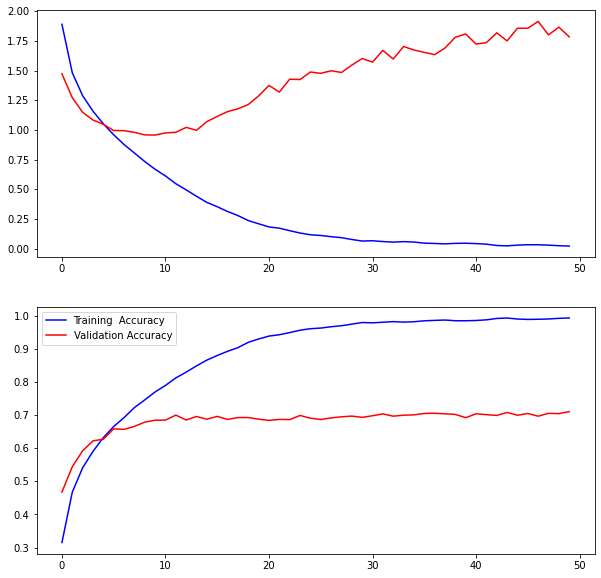

In [ ]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()



In [ ]:
print('Accuracy Score = ',np.max(history.history['val_accuracy']))

Accuracy Score =  0.7104367017745972
